<a href="https://colab.research.google.com/github/SojoodAbuAlrub/Predication-of-Cirrhosis-disease-/blob/main/ANN_for_Cirrhosis_Predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
from sklearn.pipeline import make_pipeline


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Keras
!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

#Sci-kit Learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns',800)


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import set_config
set_config(transform_output='pandas')


# Loading Data

In [4]:
data=pd.read_csv('/content/drive/MyDrive/AXSOSACADEMY (1)/05-IntermediateML/cirrhosis.csv')

In [5]:
# Checking info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

## Cleaning Data

In [6]:
# Dropping ID column
data.drop('ID', axis=1, inplace=True)

In [7]:
# Checking duplicates
data.duplicated().sum()

0

In [8]:
# Checking null values
data.isna().sum().sum()

1033

In [9]:
# Defining numericasl data and categorical data
num_cols = data.select_dtypes('number').columns
num_cols = [col for col in num_cols if col != 'ID']

cat_cols = data.select_dtypes('object').columns.drop('Status')
num_cols

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

## Imputing Null values

In [10]:
# Imputing NANs
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

imputed_num_data = numerical_imputer.fit_transform(data[num_cols])
imputed_cat_data = categorical_imputer.fit_transform(data[cat_cols])
data[num_cols] = imputed_num_data
data[cat_cols] = imputed_cat_data

## Standard Scaler

In [11]:
# Standard scaler
scaler = StandardScaler()
# Pipeline for numerical data
num_pipe = make_pipeline(scaler)
# Numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

## preprocessing

In [14]:
# Pipeline for categorical data
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
cat_tuple = ('categorical', ohe_pipe, cat_cols)

In [17]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, cat_tuple],
                                    verbose_feature_names_out=False)

# Defining X, y

In [18]:
X=data.drop('Status',axis=1)
y=data['Status']

# Split Training Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
# Fit columns transformer training data
col_transformer.fit(X_train)

# Transform the training data and testing data
X_train_tf = col_transformer.transform(X_train)
X_test_tf = col_transformer.transform(X_test)

In [21]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()

encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)

# make a record of the classes, in order of the encoding, in case we want to
classes = encoder.classes_

# binarize labels
binarizer = LabelBinarizer()

binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)

# Building multiclass classification model

In [22]:
# Define shape
input_shape = X_train_tf.shape[1]
input_shape

25

In [23]:
# Define number of classes
num_classes = len(classes)
num_classes


3

In [37]:
# Build multiclass classification model within function
def build_model():
    # Instantiate Model
    model = Sequential()

# First hidden layer
    model.add(Dense(50,
            input_dim=input_shape,
            activation='relu'))
    model.add(Dense(20,
            activation='relu'))
    model.add(Dropout(.2))
# Output layer
    model.add(Dense(num_classes, activation='softmax'))

# Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam',
          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [25]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [34]:
# Call our build function to build model
model = build_model()

# Get model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,383 (9.31 KB)

 Trainable params: 2,383 (9.31 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# fit model
history = model.fit(X_train_tf, y_train_bin,
                          validation_split = .2,
                          epochs=50,
                        callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.3813 - loss: 1.1633 - precision_3: 0.5388 - recall_3: 0.0437 - val_accuracy: 0.4921 - val_loss: 1.1519 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5531 - loss: 1.0423 - precision_3: 0.6285 - recall_3: 0.0474 - val_accuracy: 0.5556 - val_loss: 1.0576 - val_precision_3: 0.2500 - val_recall_3: 0.0159
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6068 - loss: 0.9681 - precision_3: 0.6490 - recall_3: 0.1385 - val_accuracy: 0.5714 - val_loss: 0.9829 - val_precision_3: 0.6250 - val_recall_3: 0.0794
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6333 - loss: 0.9337 - precision_3: 0.6591 - recall_3: 0.2104 - val_accuracy: 0.5873 - val_loss: 0.9183 - val_precision_3: 0.7500 - val_recall_3: 0.2381
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6199 - loss: 0.8984 - precision_3: 0.7353 - recall_3: 0.3546 - val_ac

## Plotting History

In [38]:
# Plotting history
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")

    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

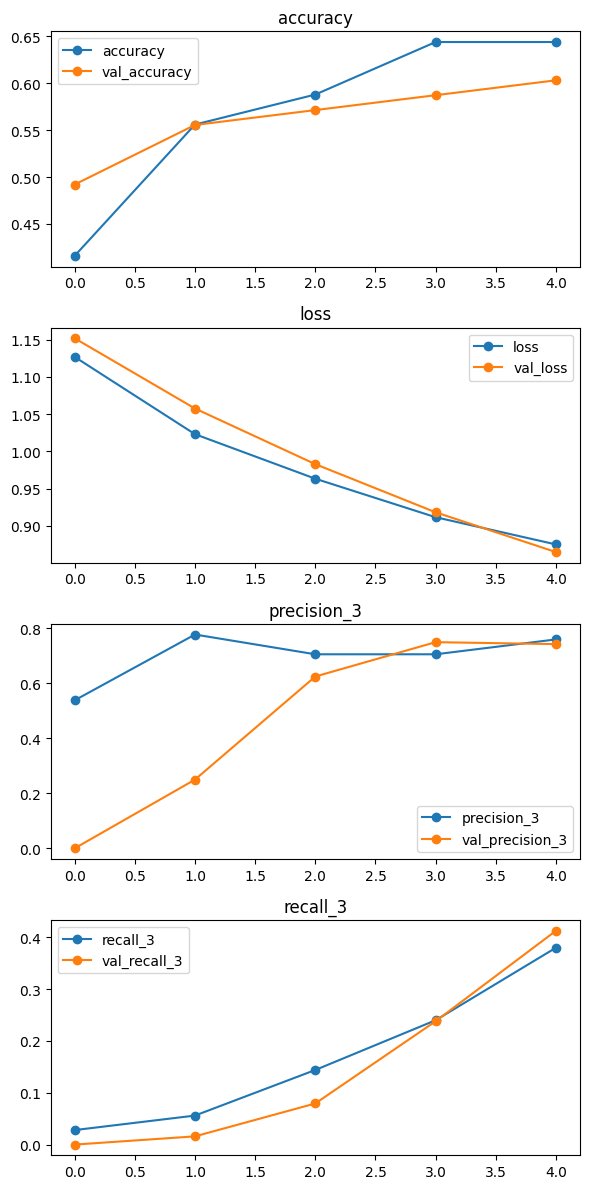

In [39]:
# visualize history
plot_history(history);

## Evaluate the model

In [42]:
# Get Predictions
predictions=model.predict(X_test_tf)
predictions.argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0])

In [45]:
predictions_score= predictions.max(axis=1)
threshold=0.8
predictions_score[predictions_score < threshold] = 0

In [49]:
# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.96      0.70        55
           1       0.33      0.17      0.22         6
           2       0.67      0.09      0.16        44

    accuracy                           0.55       105
   macro avg       0.52      0.41      0.36       105
weighted avg       0.59      0.55      0.45       105



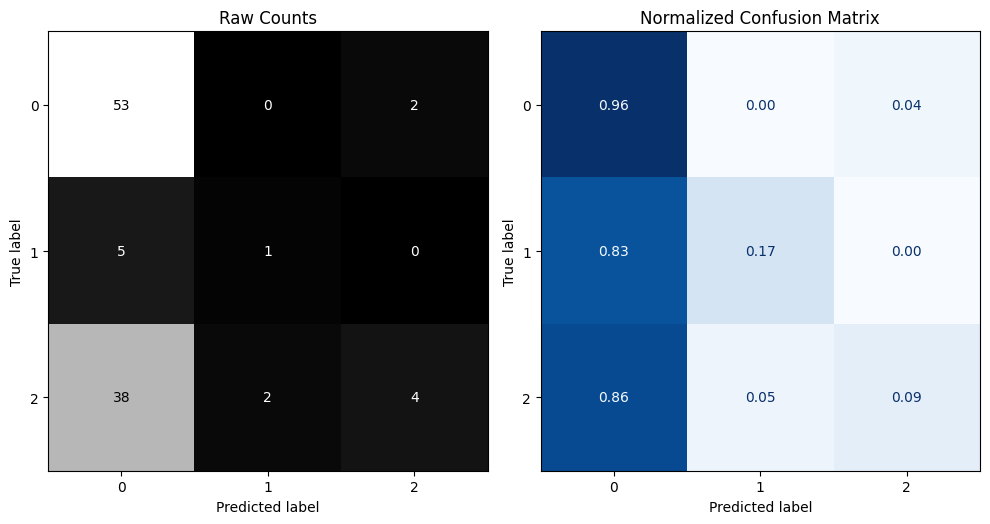

In [50]:
# Getting Sklearn Metrics
classification_metrics(y_true, y_pred, label='Test Data', figsize=(10,8));

## Tunning the model

In [64]:
# Bulding a new Model with optimizer
def build_model(hp):
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(30,
                input_dim =input_shape,
                activation = 'relu',
    ))

    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5), activation='relu',
              ))

    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    # Output
    model.add(Dense(3, activation = 'softmax'))

    # Compile Model
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1, 0.2])
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

In [67]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
                     overwrite = True,
                     seed = 42,
                    )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
# Run the tuner
tuner.search(X_train_tf, y_train_bin, epochs=50,
             validation_split=0.2,
             callbacks = [early_stopping])

Trial 90 Complete [00h 00m 07s]
val_accuracy: 0.7460317611694336

Best val_accuracy So Far: 0.8253968358039856
Total elapsed time: 00h 09m 43s


In [69]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 40,
 'dropout_value': 0.0,
 'optimizer': 'adam',
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

In [70]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │             780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             123 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143 (8.37 KB)

 Trainable params: 2,143 (8.37 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Evaluate neural network with tuned optimizer, units, and dropout
result = best_model.evaluate(X_test_tf, y_test_bin, return_dict=True)
result

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7877 - loss: 0.6256 - precision: 0.7886 - recall: 0.7364  


{'accuracy': 0.7714285850524902,
 'loss': 0.6207690238952637,
 'precision': 0.7755101919174194,
 'recall': 0.723809540271759}

In [78]:
test_loss = result["loss"]
test_accuracy = result["accuracy"]
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.6207690238952637, Test Accuracy: 0.7714285850524902
